TODO
- DONE preprocess su immagini di dimensioni reali, e resizing successivo
- migliorare data augmentation in modo che le immagini vengano molto più diverse una dall'altra

# Prepare all the dataset
Before using the following code, install necessary libraries
'pip install pandas opencv-python numpy matplotlib pillow tqdm torch torchvision torchinfo scikit-learn focal-loss-torch'

In [1]:
# =========================================================
# Librerie standard Python
# =========================================================
import os
import gc
import io
import csv
import json
import base64
import shutil
import random
import pathlib
import subprocess
import itertools
from pathlib import Path
from typing import Optional, Dict, Any, List, Callable
from collections import Counter

# =========================================================
# Librerie scientifiche e di elaborazione dati
# =========================================================
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, confusion_matrix,
    precision_score, recall_score, f1_score
)

# =========================================================
# Librerie per immagini e visualizzazione
# =========================================================
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# =========================================================
# PyTorch e moduli correlati
# =========================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

# =========================================================
# TorchVision
# =========================================================
import torchvision
from torchvision import transforms, models
from torchvision.transforms import functional

# =========================================================
# Altre librerie
# =========================================================
from torchinfo import summary
from focal_loss.focal_loss import FocalLoss

In [2]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [3]:
use_resized = 0
local_runtime = 1
download_data_from_drive = 0
use_data_preprocessing = 1
use_data_augmentation = 1
use_subset_loader = 1
preprocess_out_size = 512

In [4]:
img_size = 224
batch_size = 64

# Target per classe della data augmentation: se None, usa la massima numerosità corrente, altrimenti
# genera un numero di immagini pari al numero scelto (1000) - quante ce ne sono già
TARGET_PER_CLASS = 1000

In [5]:
if use_resized == 1:
  resized_path = 'resized_512/'
else:
  resized_path = ""
drive_zip_path = "/content/drive/MyDrive/COMPUTER VISION PROJECT/dataset/resized_512/"

if local_runtime==1:
    #base_path = "/Users/ire/Documents/2° Year/SELECTED TOPICS /project/dataset/"
    #base_path = 'C:/Users/s.simonitti/Desktop/DiabeticRetinopathyImageClassification/dataset/'
    base_path = "C:/Users/pippo/Desktop/UNI/AI & CyberSec - Klagenfurt/SelectedTopics/DiabeticRetinopathyImageClassification/dataset/"
else:
    base_path = '/content/drive/MyDrive/Colab Notebooks/dataset/'

data_dir = base_path + resized_path + 'train_images'
val_dir = base_path + resized_path + 'val_images'
test_dir = base_path + resized_path + 'test_images'
processed_train_dir = base_path + "processed_dataset/train_images"
processed_val_dir = base_path + "processed_dataset/val_images"
processed_test_dir = base_path + "processed_dataset/test_images"

if use_data_augmentation==1:
  augm_path="augmented_dataset/"
else:
  augm_path=""

augm_train_dir = base_path + augm_path + "train_images"


# csv file names
train_binary_file = "train_binary.csv"
train_four_classes_file = "train_four_classes.csv"

val_binary_file = "val_binary.csv"
val_four_classes_file = "val_four_classes.csv"

test_binary_file = "test_binary.csv"
test_four_classes_file = "test_four_classes.csv"

In [6]:
if local_runtime==0:
    drive.mount("/content/drive")

## Download zip dataset from drive and unzip it

In [7]:
def prepare_dataset_zip(
    drive_zip_path: str,
    local_zip_path: str,
    extract_dir: str,
    ready_flag: str = ".ready",
    verbose: bool = True,
    delete_zip_after_extract: bool = True,
):
    """
    Copia uno zip da Google Drive, lo estrae localmente in /content,
    e cancella lo zip dopo l'estrazione. Usa un file sentinella (.ready)
    per evitare di ripetere l'estrazione se già completata.

    Args:
        drive_zip_path (str): percorso completo allo zip su Drive.
        local_zip_path (str): percorso temporaneo per lo zip locale.
        extract_dir (str): cartella dove estrarre i file.
        ready_flag (str): nome del file sentinella per la cache.
        verbose (bool): stampa messaggi di stato se True.
        delete_zip_after_extract (bool): se True, rimuove lo zip dopo l'estrazione.

    Returns:
        str: percorso della cartella estratta (extract_dir)
    """
    extract_dir = os.path.abspath(extract_dir)
    ready_file = os.path.join(extract_dir, ready_flag)
    pathlib.Path(extract_dir).mkdir(parents=True, exist_ok=True)

    if not os.path.exists(ready_file):
        if verbose: print("Copio lo zip da Drive a /content...")
        shutil.copy(drive_zip_path, local_zip_path)

        if verbose: print("Estrazione in corso...")
        subprocess.run(["unzip", "-q", "-n", local_zip_path, "-d", extract_dir], check=True)

        # crea file sentinella
        open(ready_file, "w").close()
        if verbose: print(f"Dataset pronto in {extract_dir}")

        # rimuove zip locale per liberare spazio
        if delete_zip_after_extract and os.path.exists(local_zip_path):
            os.remove(local_zip_path)
            if verbose: print(f"File zip locale rimosso: {local_zip_path}")
    else:
        if verbose: print(f"Dataset già estratto in {extract_dir}, uso cache locale.")

    return extract_dir

In [8]:
if download_data_from_drive:
    data_dir = prepare_dataset_zip(
        drive_zip_path=drive_zip_path + "train_images.zip",
        local_zip_path=base_path + "train_images.zip",
        extract_dir=data_dir
    )
    val_dir = prepare_dataset_zip(
        drive_zip_path=drive_zip_path + "val_images.zip",
        local_zip_path=base_path + "val_images.zip",
        extract_dir=val_dir
    )
    test_dir = prepare_dataset_zip(
        drive_zip_path=drive_zip_path + "test_images.zip",
        local_zip_path=base_path + "test_images.zip",
        extract_dir=test_dir
    )

In [9]:
train_images = os.listdir(data_dir)
val_images = os.listdir(val_dir)
test_images = os.listdir(test_dir)

In [10]:
img = cv2.imread(os.path.join(data_dir, train_images[700]))
print(img.shape)

(1736, 2416, 3)


## Preprocess images
Denoise and other

In [11]:
def preprocess_retina_image(image_path):
    # 1. Load image (RGB)
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 2. Cropping eye region (remove black background)
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Find largest contour (eye region)
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    cropped_img = img_rgb[y:y+h, x:x+w]

    # 3. Denoising (Gaussian Blur, kernel size 3x3)
    denoised_img = cv2.GaussianBlur(cropped_img, (3, 3), 0)

    # 4. Histogram Equalization on Y channel (YUV color space)
    img_yuv = cv2.cvtColor(denoised_img, cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    he_img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

    final_img = cv2.resize(he_img, (preprocess_out_size, preprocess_out_size))

    return final_img

In [12]:
def process_image_batch(
    images_to_process,
    images_dir,
    out_images_dir
):
    for img_name in tqdm(images_to_process, desc="Processing Images", unit="image"):
        # 1. Determina immediatamente il percorso di salvataggio
        save_path = os.path.join(out_images_dir, img_name)

        # 2. CONTROLLO DI ESISTENZA
        if os.path.exists(save_path):
            # Se il file esiste, stampa un messaggio e passa all'immagine successiva
            # print(f"Skipping {img_name}: already processed.")
            continue # Passa all'elemento successivo nel ciclo
    
        # Se il file NON esiste, esegui il processo
        img_path = os.path.join(images_dir, img_name)
    
        try:
            # Elaborazione (viene eseguita solo se il file non esiste)
            processed_img = preprocess_retina_image(img_path)
        
            # Salvataggio
            cv2.imwrite(save_path, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))
        
        except Exception as e:
            print(f"Error processing image {img_name}: {e}")

    print(f"Finished processing and saving images to {out_images_dir}")

In [13]:
if use_data_preprocessing:
    os.makedirs(processed_train_dir, exist_ok=True)
    os.makedirs(processed_val_dir, exist_ok=True)
    os.makedirs(processed_test_dir, exist_ok=True)

    print("Processing training images...")
    process_image_batch(
        images_to_process = train_images,
        images_dir = data_dir,
        out_images_dir = processed_train_dir)

    print("Processing vaòidation images...")
    process_image_batch(
        images_to_process = val_images,
        images_dir = val_dir,
        out_images_dir = processed_val_dir)

    print("Processing testing images...")
    process_image_batch(
        images_to_process = test_images,
        images_dir = test_dir,
        out_images_dir = processed_test_dir)
else:
    processed_train_dir = data_dir
    processed_val_dir = val_dir
    processed_test_dir = test_dir

Processing training images...


Processing Images: 100%|██████████| 2931/2931 [00:00<00:00, 30271.81image/s]


Finished processing and saving images to C:/Users/pippo/Desktop/UNI/AI & CyberSec - Klagenfurt/SelectedTopics/DiabeticRetinopathyImageClassification/dataset/processed_dataset/train_images
Processing vaòidation images...


Processing Images: 100%|██████████| 366/366 [00:00<00:00, 30757.67image/s]


Finished processing and saving images to C:/Users/pippo/Desktop/UNI/AI & CyberSec - Klagenfurt/SelectedTopics/DiabeticRetinopathyImageClassification/dataset/processed_dataset/val_images
Processing testing images...


Processing Images: 100%|██████████| 366/366 [00:00<00:00, 26717.17image/s]

Finished processing and saving images to C:/Users/pippo/Desktop/UNI/AI & CyberSec - Klagenfurt/SelectedTopics/DiabeticRetinopathyImageClassification/dataset/processed_dataset/test_images


## Prepare binary classification labels

In [14]:
def crea_file_diagnosis_binaria(input_path: str, output_path: str):
    """
    Legge un file CSV/XLS con una colonna 'diagnosis' e crea un nuovo file
    in cui 'diagnosis' vale 0 se è 0, altrimenti 1.
    
    :param input_path: percorso del file di input (CSV o Excel)
    :param output_path: percorso del file di output CSV
    """
    # Legge il file (rileva automaticamente se è CSV o Excel)
    df = pd.read_csv(input_path)

    # Conversione della colonna 'diagnosis' in 0/1
    df['diagnosis'] = df['diagnosis'].apply(lambda x: 0 if x == 0 else 1)

    # Salva il nuovo file
    df.to_csv(output_path, index=False)
    print(f"File con diagnosis binaria salvato in: {output_path}")

In [15]:
crea_file_diagnosis_binaria(input_path=base_path + "train.csv.xls", output_path=base_path + train_binary_file)
crea_file_diagnosis_binaria(input_path=base_path + "val.csv.xls", output_path=base_path + val_binary_file)
crea_file_diagnosis_binaria(input_path=base_path + "test.csv.xls", output_path=base_path + test_binary_file)

File con diagnosis binaria salvato in: C:/Users/pippo/Desktop/UNI/AI & CyberSec - Klagenfurt/SelectedTopics/DiabeticRetinopathyImageClassification/dataset/train_binary.csv
File con diagnosis binaria salvato in: C:/Users/pippo/Desktop/UNI/AI & CyberSec - Klagenfurt/SelectedTopics/DiabeticRetinopathyImageClassification/dataset/val_binary.csv
File con diagnosis binaria salvato in: C:/Users/pippo/Desktop/UNI/AI & CyberSec - Klagenfurt/SelectedTopics/DiabeticRetinopathyImageClassification/dataset/test_binary.csv


## Prepare four classes labels

In [16]:
def crea_file_diagnosis_nonzero(input_path: str, output_path: str):
    """
    Legge un file CSV/XLS con una colonna 'diagnosis' e crea un nuovo file
    contenente solo le righe dove 'diagnosis' è diversa da 0.
    
    :param input_path: percorso del file di input (CSV o Excel)
    :param output_path: percorso del file di output CSV
    """
    # Legge il file (rileva automaticamente se è CSV o Excel)
    df = pd.read_csv(input_path)

    # Filtra solo le righe con diagnosis diversa da 0
    df_filtrato = df[df['diagnosis'] != 0].copy()
    df_filtrato['diagnosis'] = df_filtrato['diagnosis'].apply(lambda x: x-1)

    # Salva il nuovo file
    df_filtrato.to_csv(output_path, index=False)
    print(f"File con diagnosis != 0 salvato in: {output_path}")


In [17]:
crea_file_diagnosis_nonzero(input_path=base_path + "train.csv.xls", output_path=base_path + train_four_classes_file)
crea_file_diagnosis_nonzero(input_path=base_path + "val.csv.xls", output_path=base_path + val_four_classes_file)
crea_file_diagnosis_nonzero(input_path=base_path + "test.csv.xls", output_path=base_path + test_four_classes_file)

File con diagnosis != 0 salvato in: C:/Users/pippo/Desktop/UNI/AI & CyberSec - Klagenfurt/SelectedTopics/DiabeticRetinopathyImageClassification/dataset/train_four_classes.csv
File con diagnosis != 0 salvato in: C:/Users/pippo/Desktop/UNI/AI & CyberSec - Klagenfurt/SelectedTopics/DiabeticRetinopathyImageClassification/dataset/val_four_classes.csv
File con diagnosis != 0 salvato in: C:/Users/pippo/Desktop/UNI/AI & CyberSec - Klagenfurt/SelectedTopics/DiabeticRetinopathyImageClassification/dataset/test_four_classes.csv


## Data Augmentation

In [18]:
class FundusAugment:
    """
    Augmentations secondo Tabella 3:
    - Zoom range: 0.2  -> scale (0.8, 1.0)
    - Rotation range: ±10°
    - Flip: orizzontale + verticale
    - Brightness/Color(=Saturation)/Contrast: (0.5, 1.5)
    """
    def __init__(
        self,
        img_size: 512,
        p_zoom: float = 0.7,
        p_hflip: float = 0.5,
        p_vflip: float = 0.5,
        p_rotate: float = 1,
        p_color: float = 1,
        zoom_scale=(0.80, 1.00),
        zoom_ratio=(0.95, 1.05),
        rot_deg: float = 20.0,
        brightness=(0.5, 1.5),
        contrast=(0.5, 1.5),
        color_adjustment=(0.5, 1.5)
    ):
        self.img_size = img_size
        self.p_zoom = p_zoom
        self.p_hflip = p_hflip
        self.p_vflip = p_vflip
        self.p_rotate = p_rotate
        self.p_color = p_color
        self.zoom_scale = zoom_scale
        self.zoom_ratio = zoom_ratio
        self.rot_deg = rot_deg
        self.resize = transforms.Resize((img_size, img_size))

        self.color_jitter = transforms.ColorJitter(
            brightness=brightness,
            contrast=contrast,
            saturation=color_adjustment,
            hue=0.0
        )

    def __call__(self, img: Image.Image) -> Image.Image:
        img = self.resize(img)

        if random.random() < self.p_zoom:
            rrc = transforms.RandomResizedCrop(
                self.img_size, scale=self.zoom_scale#, ratio=self.zoom_ratio
            )
            img = rrc(img)

        if random.random() < self.p_hflip:
            img = functional.hflip(img)
        if random.random() < self.p_vflip:
            img = functional.vflip(img)

        if random.random() < self.p_rotate:
            angle = random.uniform(-self.rot_deg, self.rot_deg)
            img = functional.rotate(img, angle, interpolation=Image.BICUBIC, expand=False, fill=0)

        if random.random() < self.p_color:
            img = self.color_jitter(img)

        return img
  
# -----------------------------
# UTILS
# -----------------------------
EXTS = [".jpg", ".jpeg", ".png", ".tif", ".tiff", ".bmp", ".webp"]

def find_image_for_id(id_code: str, root: Path) -> Path | None:
    for ext in EXTS:
        p = root / f"{id_code}{ext}"
        if p.exists():
            return p
    # fallback: cerca per pattern (es. file con id_code come prefisso)
    matches = list(root.glob(f"{id_code}.*"))
    return matches[0] if matches else None

def load_df(csv_path: Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    cols = [c.lower() for c in df.columns]
    # normalizza nomi colonne attese
    if "id_code" in cols and "diagnosis" in cols:
        return df.rename(columns={df.columns[cols.index("id_code")]: "id_code",
                                  df.columns[cols.index("diagnosis")]: "diagnosis"})
    elif "filepath" in cols and "diagnosis" in cols:
        return df.rename(columns={df.columns[cols.index("filepath")]: "filepath",
                                  df.columns[cols.index("diagnosis")]: "diagnosis"})
    else:
        raise ValueError("CSV deve avere colonne (id_code,diagnosis) oppure (filepath,diagnosis).")

def row_to_path(row, dir_img) -> Path:
    if "filepath" in row and isinstance(row["filepath"], str):
        return Path(row["filepath"])
    # se abbiamo id_code, cerchiamo il file nella cartella root
    return find_image_for_id(str(row["id_code"]), dir_img)


In [19]:
if use_data_augmentation==1:
  # Percorsi
  TRAIN_IMG_DIR = Path(processed_train_dir)
  TRAIN_CSV_IN  = Path(base_path + train_four_classes_file)
  TRAIN_CSV_OUT = Path(base_path + augm_path + train_four_classes_file)
  # Dove salvare i nuovi file
  OUT_IMG_DIR = Path(augm_train_dir)
  # -----------------------------
  # CONFIG
  # -----------------------------
  SEED = 42
  random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

  # Modalità CSV out: "w" per riscrivere tutto (originali + augment), "a" per appendere solo le nuove righe
  CSV_MODE = "w"
  WRITE_HEADER = True if CSV_MODE == "w" else False
  
  # Se la cartella di output contiene già immagini aumentate, salta tutto
  if OUT_IMG_DIR.exists() and any(OUT_IMG_DIR.glob("*.png")):
      print(f"Data augmentation già eseguita: trovate immagini in {OUT_IMG_DIR}.")
      print("Salto la rigenerazione e uso i file esistenti.")
  else:
    OUT_IMG_DIR.mkdir(parents=True, exist_ok=True)
    # Colonna per l'output: "id_code" (consigliato se il tuo Dataset fa f"{id_code}.jpg") oppure "filepath"
    OUTPUT_USES_ID_CODE = True

    augment = FundusAugment(img_size=preprocess_out_size)

    # -----------------------------
    # CARICA CSV E CONTA PER CLASSE
    # -----------------------------
    df_in = load_df(TRAIN_CSV_IN)
    df_in["diagnosis"] = df_in["diagnosis"].astype(int)

    # calcola counts per classe dal CSV
    counts = df_in.groupby("diagnosis").size().to_dict()
    all_classes = sorted(df_in["diagnosis"].unique().tolist())
    if TARGET_PER_CLASS is None:
      TARGET_PER_CLASS = max(counts.values())

    print("Conteggi iniziali:", counts)
    print("Target per classe:", TARGET_PER_CLASS)

    # mappa: classe -> lista (id_code, path)
    by_class = {c: [] for c in all_classes}
    for _, row in df_in.iterrows():
      p = row_to_path(row, TRAIN_IMG_DIR)
      if p is None or not p.exists():
        # salta righe orfane
        continue
      if "id_code" in df_in.columns:
        by_class[row["diagnosis"]].append((str(row["id_code"]), p))
      else:
        # crea un id_code dal filename (senza estensione)
        by_class[row["diagnosis"]].append((p.stem, p))

    # contatori per generare suffissi univoci per ciascun id_code base
    per_id_counters = {}

    # -----------------------------
    # PREPARA CSV DI OUTPUT
    # -----------------------------
    TRAIN_CSV_OUT.parent.mkdir(parents=True, exist_ok=True)
    mode = CSV_MODE
    write_header = WRITE_HEADER
    fout = open(TRAIN_CSV_OUT, mode, newline="", encoding="utf-8")
    writer = csv.writer(fout)

    # Decidi intestazioni e funzione che scrive una riga
    if OUTPUT_USES_ID_CODE:
      if write_header:
        writer.writerow(["id_code", "diagnosis"])
      def write_row_id(id_code: str, diagnosis: int):
        writer.writerow([id_code, diagnosis])
    else:
      if write_header:
        writer.writerow(["filepath", "diagnosis"])
      def write_row_path(path: Path, diagnosis: int):
        writer.writerow([str(path), diagnosis])

  # se stai riscrivendo tutto, copia anche le righe originali nel nuovo CSV
    if mode == "w":
      for c in all_classes:
          for id_code, path in by_class[c]:
            if OUTPUT_USES_ID_CODE:
                write_row_id(id_code, c)
            else:
                write_row_path(path, c)

  # -----------------------------
  # GENERA AUGMENT PER RAGGIUNGERE IL TARGET
  # -----------------------------
    for c in all_classes:
      current = len(by_class[c])
      need = max(0, TARGET_PER_CLASS - current)
      if need == 0:
        continue

      print(f"Classe {c}: genero {need} immagini…")
      src_items = by_class[c]
      if not src_items:
        continue

      for i in tqdm(range(need), desc=f"Augment class {c}"):
        base_id, src_path = random.choice(src_items)
        with Image.open(src_path) as im:
            im = im.convert("RGB")
            aug_img = augment(im)

        # genera nome univoco
        k = per_id_counters.get(base_id, 0)
        per_id_counters[base_id] = k + 1
        new_id = f"{base_id}aug{k:05d}"
        out_path = OUT_IMG_DIR / f"{new_id}.png"

        # evita collisioni nel raro caso il file esista
        while out_path.exists():
            k += 1
            per_id_counters[base_id] = k + 1
            new_id = f"{base_id}aug{k:05d}"
            out_path = OUT_IMG_DIR / f"{new_id}.png"

        aug_img.save(out_path, format="PNG", quality=92, optimize=True, progressive=True)

        # scrivi riga CSV per la nuova immagine
        if OUTPUT_USES_ID_CODE:
            write_row_id(new_id, c)
        else:
            write_row_path(out_path, c)

    src = Path(processed_train_dir)
    dst = Path(augm_train_dir)

    # Copia tutto il contenuto (anche sottocartelle e file)
    shutil.copytree(src, dst, dirs_exist_ok=True)
    fout.close()
    print(f"Immagini nuove in: {OUT_IMG_DIR}")
    print(f"CSV scritto in: {TRAIN_CSV_OUT}")
else:
  augm_train_dir = processed_train_dir

Data augmentation già eseguita: trovate immagini in C:\Users\pippo\Desktop\UNI\AI & CyberSec - Klagenfurt\SelectedTopics\DiabeticRetinopathyImageClassification\dataset\augmented_dataset\train_images.
Salto la rigenerazione e uso i file esistenti.


## Load image names and labes

In [20]:
labels_train_binary = pd.read_csv(base_path + train_binary_file)
labels_val_binary = pd.read_csv(base_path + val_binary_file)
labels_test_binary = pd.read_csv(base_path + test_binary_file)

labels_train_four_classes = pd.read_csv(base_path + augm_path + train_four_classes_file)
labels_val_four_classes = pd.read_csv(base_path + val_four_classes_file)
labels_test_four_classes = pd.read_csv(base_path + test_four_classes_file)

## Check dataset

In [21]:
def show_dataset_statistics(msg: str, train_labels, val_labels, test_labels):
    table_cnt = pd.DataFrame({
        'TRAIN': train_labels['diagnosis'].value_counts().sort_index(),
        'TEST': val_labels['diagnosis'].value_counts().sort_index(),
        'VALIDATION': test_labels['diagnosis'].value_counts().sort_index()
    }).T

    table_perc = pd.DataFrame({
    'TRAIN': round(train_labels['diagnosis'].value_counts(normalize=True).sort_index() * 100, 3),
    'TEST': round(val_labels['diagnosis'].value_counts(normalize=True).sort_index() * 100, 3),
    'VALIDATION': round(test_labels['diagnosis'].value_counts(normalize=True).sort_index() * 100, 3)
    }).T  # trasponi per avere i dataset come righe

    # Mostra le tabella
    print(msg)
    print("Dataset count")
    print(table_cnt)
    print("\nDataset percentage")
    print(table_perc)

    train_labels['diagnosis'].value_counts().plot(kind = 'bar', color = ['red', 'blue', 'green', 'cyan', 'purple'])

Binary dataset:
Dataset count
diagnosis      0     1
TRAIN       1434  1496
TEST         172   194
VALIDATION   199   167

Dataset percentage
diagnosis        0       1
TRAIN       48.942  51.058
TEST        46.995  53.005
VALIDATION  54.372  45.628


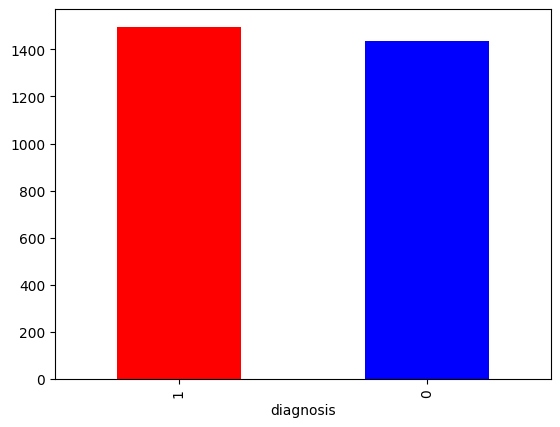

In [22]:
show_dataset_statistics("Binary dataset:", labels_train_binary, labels_val_binary, labels_test_binary)

Four classes dataset:
Dataset count
diagnosis      0     1     2     3
TRAIN       1000  1000  1000  1000
TEST          40   104    22    28
VALIDATION    30    87    17    33

Dataset percentage
diagnosis        0       1      2       3
TRAIN       25.000  25.000  25.00  25.000
TEST        20.619  53.608  11.34  14.433
VALIDATION  17.964  52.096  10.18  19.760


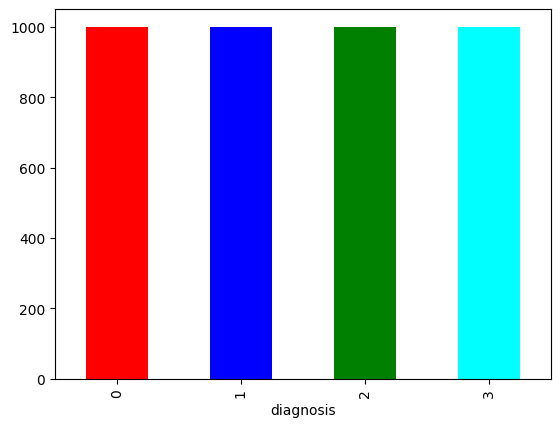

In [23]:
show_dataset_statistics("Four classes dataset:", labels_train_four_classes, labels_val_four_classes, labels_test_four_classes)

## Set up transformation

In [24]:
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    #transforms.CenterCrop(img_size),
    transforms.ToTensor(),               # convert to tensor [0,1]
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],      # ImageNet mean
        std=[0.229, 0.224, 0.225]
    )
])

## Define custom Dataset

In [25]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, labels_df, transform=None, preload=True):
        self.img_dir = img_dir
        self.labels_df = labels_df
        self.transform = transform
        self.preload = preload

        # Map filenames and labels
        self.filenames = self.labels_df['id_code'].values
        self.labels = self.labels_df['diagnosis'].values

        self.images = []  # qui salveremo le immagini pre-caricate

        if self.preload:
            print("Caricamento immagini in RAM...")
            for fname in tqdm(self.filenames, desc="Caricamento immagini", unit="img"):
                img_path = os.path.join(self.img_dir, fname + ".png")
                image = Image.open(img_path).convert("RGB")

                if self.transform:
                    image = self.transform(image)

                self.images.append(image)
            print(f"Caricate {len(self.images)} immagini in memoria.")

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        if self.preload:
            image = self.images[idx]
        else:
            img_path = os.path.join(self.img_dir, self.filenames[idx] + ".png")
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)

        label = self.labels[idx]

        # If label is not numeric, convert to class index
        if isinstance(label, str):
            # Optional: map string labels to integers
            # You can build a mapping outside this class
            raise ValueError("Labels are strings. Convert them to int first.")

        return image, label


In [26]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda') # Uncomment this to run on GPU
device

device(type='cuda')

In [27]:
num_cuda_devices = torch.cuda.device_count()
print(f"CUDA è disponibile. Numero di dispositivi GPU: {num_cuda_devices}")

# (Opzionale) Stampa il nome di ciascun dispositivo
for i in range(num_cuda_devices):
    print(f"Dispositivo {i}: {torch.cuda.get_device_name(i)}")

CUDA è disponibile. Numero di dispositivi GPU: 1
Dispositivo 0: NVIDIA GeForce RTX 4060 Laptop GPU


## Create datasets and loaders

Caricamento dataset sulla RAM (set FALSE se non vuoi)

In [28]:
if local_runtime==1:
    train_set_preload = True
else:
    train_set_preload = False

train_set_preload = True

train_set_binary = CustomImageDataset(augm_train_dir, labels_train_binary, transform=transform, preload=train_set_preload)
train_loader_binary = DataLoader(train_set_binary, batch_size=batch_size, shuffle=True)
val_set_binary = CustomImageDataset(processed_val_dir, labels_val_binary, transform=transform, preload=False)
val_loader_binary = DataLoader(val_set_binary, batch_size=batch_size, shuffle=False)
test_set_binary = CustomImageDataset(processed_test_dir, labels_test_binary, transform=transform, preload=False)
test_loader_binary = DataLoader(test_set_binary, batch_size=batch_size, shuffle=False)

train_set_four_classes = CustomImageDataset(augm_train_dir, labels_train_four_classes, transform=transform, preload=train_set_preload)
train_loader_four_classes = DataLoader(train_set_four_classes, batch_size=batch_size, shuffle=True)
val_set_four_classes = CustomImageDataset(processed_val_dir, labels_val_four_classes, transform=transform, preload=False)
val_loader_four_classes = DataLoader(val_set_four_classes, batch_size=batch_size, shuffle=False)
test_set_four_classes = CustomImageDataset(processed_test_dir, labels_test_four_classes, transform=transform, preload=False)
test_loader_four_classes = DataLoader(test_set_four_classes, batch_size=batch_size, shuffle=False)

Caricamento immagini in RAM...


Caricamento immagini: 100%|██████████| 2930/2930 [00:16<00:00, 174.95img/s]


Caricate 2930 immagini in memoria.
Caricamento immagini in RAM...


Caricamento immagini: 100%|██████████| 4000/4000 [00:24<00:00, 163.22img/s]

Caricate 4000 immagini in memoria.


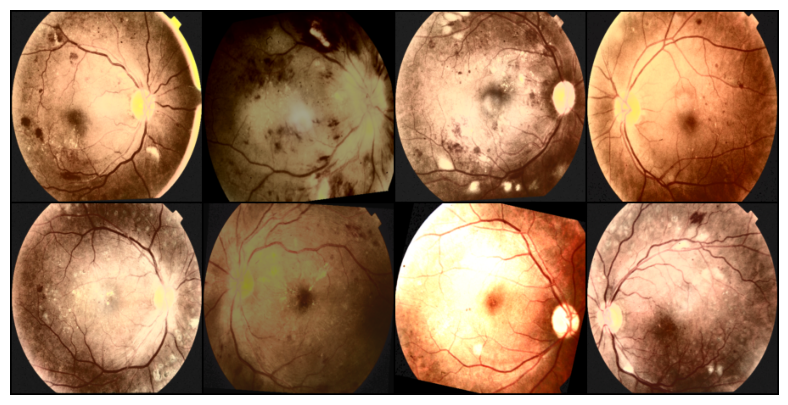

Labels: [1, 3, 2, 0, 3, 2, 0, 1]


In [29]:
# Get one batch from the DataLoader
images, labels = next(iter(train_loader_four_classes))  # images: [B, 3, 224, 224], labels: [B]

# Denormalize for display (undo ImageNet normalization)
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
images = images * std + mean  # undo normalization

# Make a grid of images
grid = torchvision.utils.make_grid(images[:8], nrow=4)  # first 8 images, 4 per row

# Convert to numpy for matplotlib (C,H,W -> H,W,C)
grid_np = grid.permute(1, 2, 0).numpy()

# Plot the images
plt.figure(figsize=(10, 5))
plt.imshow(grid_np)
plt.axis('off')
plt.show()

# Print corresponding labels
print("Labels:", labels[:8].tolist())

## Subset Loader

In samples_per_class decidere quanti samples prendere per avere una distribuzione equa

In [30]:

def create_subset_loader(train_labels, train_set, num_classes, samples_per_class = 700):
    # Dictionary to hold indices for each class
    class_indices = {c: [] for c in range(num_classes)}

    # Iterate through dataset and collect indices by class
    for idx, row in train_labels.iterrows():
        label = int(row['diagnosis'])
        class_indices[label].append(idx)

    # For each class, randomly sample X indices
    subset_indices = []
    for c in range(num_classes):
        chosen = np.random.choice(class_indices[c], samples_per_class, replace=False)
        subset_indices.extend(chosen)

    # Shuffle the final list of subset indices
    np.random.shuffle(subset_indices)

    # Create a subset of the dataset
    subset_dataset = Subset(train_set, subset_indices)

    # Create a new DataLoader for the subset
    return DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)

In [31]:
# Error with subset loader, beacuse now it has consider that binary classification only has 2 classes, and multiclass only has 4.
# So we would need to update the method create_subset_loader to address that
if use_subset_loader == 1:
    #loader_selected_binary = create_subset_loader(train_labels = labels_train_binary, train_set = train_set_binary, num_classes = 2, samples_per_class = 700)
    loader_selected_binary = train_loader_binary
    loader_selected_four_classes = create_subset_loader(train_labels = labels_train_four_classes, train_set = train_set_four_classes, num_classes = 4, samples_per_class = 600)
else:
    loader_selected_binary = train_loader_binary
    loader_selected_four_classes = train_loader_four_classes

In [41]:
def collect_label_counts(loader, num_classes=None):
    counts = Counter()
    for _, labels in loader:
        # If labels are one-hot (B, C), convert to class indices
        if labels.ndim == 2 and (num_classes is None or labels.size(1) == num_classes):
            labels = labels.argmax(dim=1)

        # If labels have an extra singleton dim (B,1), squeeze it
        if labels.ndim > 1:
            labels = labels.squeeze()

        # Ensure integer class indices
        labels = labels.long()

        counts.update(labels.tolist())
    return counts

if use_subset_loader == 1:
    # binary task (num_classes = 2)
    bin_counts = collect_label_counts(loader_selected_binary, num_classes=2)
    print("Binary distribution:", bin_counts)
    # Example usage:
    # four-class task AFTER remapping 1..4 -> 0..3  (num_classes = 4)
    four_cls_counts = collect_label_counts(loader_selected_four_classes, num_classes=4)
    print("Four-class distribution:", four_cls_counts)


Binary distribution: Counter({1: 1496, 0: 1434})
Four-class distribution: Counter({0: 600, 2: 600, 1: 600, 3: 600})


## Helper function for model training and evaluation

In [42]:
def build_optimizer(
    name: str,
    params,
    lr: None
) -> optim.Optimizer:
    """
    Crea un optimizer da stringa. Esempi:
    'adam', 'sgd', 'adamw', 'rmsprop', 'adagrad'
    opt_kwargs: qualunque parametro aggiuntivo (es. weight_decay, momentum...)
    """
    name = name.strip().lower()
    if name == "adam":
        if lr is None:
            return optim.Adam(params)
        else:
            return optim.Adam(params, lr=lr)
    if name == "adamw":
        if lr is None:
            return optim.AdamW(params)
        else:
            return optim.AdamW(params, lr=lr)
    if name == "sgd":
        if lr is None:
            return optim.SGD(params)
        else:
            return optim.SGD(params, lr=lr)
    if name == "rmsprop":
        if lr is None:
            return optim.RMSprop(params)
        else:
            return optim.RMSprop(params, lr=lr)
    if name == "adagrad":
        if lr is None:
            return optim.Adagrad(params)
        else:
            return optim.Adagrad(params, lr=lr)
    raise ValueError(f"Optimizer sconosciuto: '{name}'")

def is_focal_loss(
    name: str
) -> nn.Module:
    name = name.strip().lower()
    if name in ("focal", "focallos"):
        return True
    else:
        return False

def build_criterion(
    name: str
) -> nn.Module:
    """
    Crea una loss da stringa. Esempi:
    'crossentropy', 'bcelogits', 'mse', 'nll', 'smoothl1'
    loss_kwargs: parametri extra (es. weight, reduction, label_smoothing...)
    """
    name = name.strip().lower()
    if name in ("crossentropy", "crossentropyloss", "ce"):
        return nn.CrossEntropyLoss()
    if name in ("bcelogits", "bcelosslogits", "bcelogitsloss"):
        return nn.BCEWithLogitsLoss()
    if name in ("bce", "bceloss"):
        return nn.BCELoss()
    if name in ("bce_logits"):
        return nn.BCEWithLogitsLoss()
    if name in ("mse", "mseloss", "l2"):
        return nn.MSELoss()
    if name in ("nll", "nllloss"):
        return nn.NLLLoss()
    if name in ("smoothl1", "huber"):
        return nn.SmoothL1Loss()
    if is_focal_loss(name):
        return FocalLoss(gamma=2.0)
    raise ValueError(f"Criterion sconosciuto: '{name}'")

def build_scheduler(name: str, optimizer) -> nn.Module:
    name = name.strip().lower()
    if name in ("reducelronplateau"):
        return ReduceLROnPlateau(
            optimizer,
            mode='min',       # because we want to minimize val_loss
            factor=0.3,       # reduce LR by 0.3
            patience=2,       # wait 2 epochs before reducing LR
        )
    else:
        return None

In [43]:
def multiclass_accuracy(outputs: torch.Tensor, targets: torch.Tensor) -> float:
    """
    Calcola l'accuracy per classificazione multi-classe (es. 5 classi).
    outputs: tensor [N, num_classes]
    targets: tensor [N]
    """
    preds = outputs.argmax(dim=1)
    correct = (preds == targets).sum().item()
    total = targets.size(0)
    return correct / max(1, total)

def binary_accuracy(outputs: torch.Tensor, targets: torch.Tensor) -> float:
    """
    Calcola l'accuracy per classificazione binaria.
    outputs: tensor [N, 1] o [N]
    targets: tensor [N] - etichette binarie (0 o 1)
    """
    preds = (outputs >= 0.5).long().view(-1)
    correct = (preds == targets.long()).sum().item()
    total = targets.size(0)
    return correct / max(1, total)


In [44]:
def train_model(
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: None,
    optimizer_name: "adam",
    criterion_name: "crossentropy",
    lr: None,
    num_epochs: 5,
    device: None,
    scheduler_name = "",
    verbose: bool = True,
    model_output_softmax = False,
    model_output_binary = False
) -> Dict[str, List[float]]:
    """
    Esegue training (e opzionalmente validazione) per num_epochs.
    Ritorna uno storico con 'step_losses', 'epoch_losses', 'val_losses'.
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = build_criterion(criterion_name)
    optimizer = build_optimizer(optimizer_name, model.parameters(), lr=lr)
    uses_focal_loss = is_focal_loss(criterion_name)
    scheduler = build_scheduler(scheduler_name, optimizer)

    history = {
        "step_losses": [],
        "epoch_losses": [],
        "val_losses": [],
        "epoch_acc": [],
        "val_acc": []
    }


    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        correct_train = 0
        total_train = 0

        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs}")
            train_iter = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        else:
            train_iter = enumerate(train_loader)

        for _, (images, labels) in train_iter:
            if criterion_name == "bce_logits":
                labels = labels.float().to(device)
            else:
                labels = labels.to(device)
            
            images = images.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            if uses_focal_loss and not model_output_softmax:
                loss = criterion(torch.softmax(outputs, dim=-1), labels)
            else:
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # --- metriche ---
            is_binary_output = (
                outputs.dim() == 1 or
                (outputs.dim() == 2 and outputs.size(1) == 1)
            )

            if model_output_binary:
                acc = binary_accuracy(outputs, labels)
            else:
                acc = multiclass_accuracy(outputs, labels)
            correct_train += acc * labels.size(0)
            total_train += labels.size(0)

            epoch_loss += loss.item()
            history["step_losses"].append(loss.item())

            if verbose:
                if hasattr(train_iter, "set_description"):
                    train_iter.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
                if hasattr(train_iter, "set_postfix"):
                    train_iter.set_postfix(loss=loss.item(), acc=acc)

        avg_epoch_loss = epoch_loss / max(1, len(train_loader))
        epoch_acc = correct_train / max(1, total_train)
        history["epoch_losses"].append(avg_epoch_loss)
        history["epoch_acc"].append(epoch_acc)

        # Validazione (se fornito val_loader)
        if val_loader is not None:
            model.eval()
            val_loss_total = 0.0
            correct_val = 0
            total_val = 0
            n_val_batches = 0
            with torch.no_grad():
                val_iter = tqdm(val_loader, total=len(val_loader), leave=False) if verbose else val_loader
                for X_val, Y_val in val_iter:
                    X_val = X_val.to(device)

                    # change labels type if binary loss
                    if criterion_name == "bce_logits" or criterion_name == "bce":
                        Y_val = Y_val.float().to(device)
                    else:
                        Y_val = Y_val.to(device)

                    Y_pred_val = model(X_val)
                    
                    if uses_focal_loss:
                        loss_val = criterion(torch.softmax(Y_pred_val, dim=-1), Y_val)
                    else:
                        loss_val = criterion(Y_pred_val, Y_val)

                    val_loss_total += loss_val.item()

                    if model_output_binary:
                        acc_val = binary_accuracy(Y_pred_val, Y_val)
                    else:
                        acc_val = multiclass_accuracy(Y_pred_val, Y_val)
                    correct_val += acc_val * Y_val.size(0)
                    total_val += Y_val.size(0)

                    n_val_batches += 1

            avg_val_loss = val_loss_total / max(1, n_val_batches)
            val_acc = correct_val / max(1, total_val)
            history["val_losses"].append(avg_val_loss)
            history["val_acc"].append(val_acc)
            if verbose:
                print(f"Epoch {epoch+1} training loss: {avg_epoch_loss:.4f} train acc={epoch_acc:.4f}, validation loss: {avg_val_loss:.4f} validation acc={val_acc:.4f}")
        else:
            # se non c'è validazione, manteniamo lunghezze allineate
            history["val_losses"].append(float('nan'))
            history["val_acc"].append(float('nan'))
            if verbose:
                print(f"Epoch {epoch+1} training loss: {avg_epoch_loss:.4f} train acc={epoch_acc:.4f}")

        # Step dello scheduler (se presente)
        if scheduler is not None:
            # Alcuni scheduler richiedono val_loss (es. ReduceLROnPlateau)
            if hasattr(scheduler, 'step') and scheduler.__class__.__name__.lower().startswith('reducelronplateau'):
                last_val = history["val_losses"][-1]
                # usa train loss se non c'è validazione
                metric = last_val if not (last_val != last_val) else avg_epoch_loss
                scheduler.step(metric)
            else:
                scheduler.step()

    return history, model


In [45]:
def plot_history(history, figsize=(15, 5), save_path=None, show=True):
    """
    Mostra (e opzionalmente salva) tre grafici:
      1. Step Losses (per batch)
      2. Epoch Losses (train e validation)
      3. Epoch Accuracy (train e validation)

    Parametri
    ----------
    history : dict
        Dizionario prodotto da train_model, con chiavi:
            - "step_losses": perdite per batch
            - "epoch_losses": perdite medie di training per epoca
            - "val_losses": perdite medie di validazione per epoca
            - "epoch_acc": accuracy di training per epoca
            - "val_acc": accuracy di validazione per epoca
    figsize : tuple
        Dimensioni della figura (default: (15, 4))
    save_path : str, opzionale
        Se specificato, salva il grafico nel percorso indicato.
    show : bool
        Se True mostra il grafico (default: True)
    title : str
        Titolo generale della figura.
    """
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # --- Step losses (batch) ---
    axes[0].plot(history["step_losses"])
    axes[0].set_title("Step Losses")
    axes[0].set_xlabel("Step")
    axes[0].set_ylabel("Loss")

    # --- Epoch losses (train + val) ---
    axes[1].plot(history["epoch_losses"], label="Training Loss")
    axes[1].plot(history["val_losses"], label="Validation Loss")
    axes[1].set_title("Epoch Losses")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].legend()

    axes[2].plot(history.get("epoch_acc", []), label="Training Accuracy", marker='o')
    axes[2].plot(history.get("val_acc", []), label="Validation Accuracy", marker='o')
    axes[2].set_title("Epoch Accuracy")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("Accuracy")
    axes[2].set_ylim(0, 1)
    axes[2].legend()
    #axes[2].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
    if show:
        plt.show()

    return fig, axes


In [46]:
def evaluate_model(
    model,
    test_loader,
    average: str = "macro",
    show_confusion: bool = False
):
    """
    Valuta il modello sul test set e restituisce le metriche principali.

    Parametri
    ----------
    model : torch.nn.Module
        Il modello PyTorch da valutare.
    test_loader : DataLoader
        Dataloader del set di test.
    average : str
        Tipo di media per precision/recall/F1 ("macro", "micro", "weighted", "binary").
    show_confusion : bool
        Se True, stampa anche la matrice di confusione.

    Ritorna
    -------
    metrics : dict
        Dizionario con chiavi:
        - "accuracy"
        - "precision"
        - "recall"
        - "f1"
        - "confusion_matrix" (se show_confusion=True)
    """
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            is_binary_output = (
                outputs.dim() == 1 or
                (outputs.dim() == 2 and outputs.size(1) == 1)
            )

            if is_binary_output:
                # caso binario: usa sigmoid + soglia 0.5
                if outputs.dim() == 2 and outputs.size(1) == 1:
                    outputs = outputs.squeeze(1)        # [B]
                probs = torch.sigmoid(outputs)          # [B]
                preds = (probs >= 0.5).long()           # 0/1
            else:
                # caso multi-classe: argmax sui logit
                preds = torch.argmax(outputs, dim=1)


            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # --- Calcolo metriche ---
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average=average, zero_division=0)
    rec = recall_score(all_labels, all_preds, average=average, zero_division=0)
    f1 = f1_score(all_labels, all_preds, average=average, zero_division=0)

    metrics = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }

    cm = confusion_matrix(all_labels, all_preds)
    if show_confusion:
        metrics["confusion_matrix"] = cm
        print("\nConfusion Matrix:\n", cm)

    print(f"Test Accuracy: {acc * 100:.2f}% | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")

    return metrics, cm


In [47]:
def cleanup_torch_env(model_name: None):
    """
    Pulisce in sicurezza l'ambiente PyTorch:
    - Sposta il modello su CPU (se esiste)
    - Elimina l'optimizer (se esiste)
    - Elimina eventuali variabili temporanee note
    - Esegue garbage collection e svuota la cache GPU

    Parametri
    ----------
    model_name : str
        Nome della variabile modello da spostare su CPU.
    optimizer_name : str
        Nome della variabile optimizer da eliminare.
    """
    # --- Sposta modello su CPU ---
    if model_name in globals():
        globals()[model_name] = globals()[model_name].cpu()
    elif model_name in locals():
        locals()[model_name] = locals()[model_name].cpu()

    # --- Cancella variabili temporanee ---
    temp_vars = [
        'outputs', 'loss', 'images', 'labels',
        'Y_pred_val', 'X_val', 'Y_val',
        'sample_preds_labels', 'sample_labels',
        'sample_images', 'sample_preds',
        'all_labels', 'all_preds'
    ]

    for var in temp_vars:
        if var in globals():
            del globals()[var]
        elif var in locals():
            del locals()[var]

    # --- Garbage collector e cache GPU ---
    gc.collect()
    torch.cuda.empty_cache()

## Grid search helpers

Definire in una griglia tutti i parametri che si vogliono testare: diversi optimizer (SGD, Adam, AdamW), diversi learning rates ecc. La funzione andrà a provare tutte le combinazioni possibili dei parametri inseriti nella griglia.

In [48]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)

def fig_to_base64(fig) -> str:
    """Converte una figura Matplotlib in stringa base64 PNG e chiude la figura."""
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=200, bbox_inches="tight")
    buf.seek(0)
    b64 = base64.b64encode(buf.read()).decode("utf-8")
    plt.close(fig)
    return b64

def get_train_size(train_loader) -> int:
    return len(train_loader.dataset)

def run_experiments_to_single_csv(
    model_fn: Callable[[], torch.nn.Module],
    train_loader,
    val_loader,
    test_loader,
    param_grid: Dict[str, List[Any]],
    model_name: str = "model",
    csv_folder = base_path+"/results/",
    num_epochs: int = 5,
    seed: int = 42,
    device: Optional[torch.device] = None,
    model_output_softmax = False
    ):
    os.makedirs(csv_folder, exist_ok=True)
    """
    Esegue tutte le combinazioni e APPENDE una riga per run a un unico CSV.
    La riga contiene: parametri, dimensioni train set, metriche test, cm (json), plot (base64).
    """
    set_seed(seed)

    keys = list(param_grid.keys())
    combos = list(itertools.product(*(param_grid[k] for k in keys)))
    print(f"Partono {len(combos)} esperimenti...\n")

    # Prepara CSV: scrivi header solo se non esiste
    out_csv_path = csv_folder+model_name+".csv"
    write_header = not os.path.exists(out_csv_path)

    for i, values in enumerate(combos, 1):
        params = {k: v for k, v in zip(keys, values)}
        run_name = f"{model_name}_run_{i:03d}_" + "_".join(f"{k}={v}" for k, v in params.items())
        print(f"[{i}/{len(combos)}] {run_name}")

        # Nuovo modello per ogni run
        model = model_fn()
        train_size = get_train_size(train_loader)

        # Train
        history, model = train_model(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                optimizer_name=params["optimizer_name"],
                criterion_name=params["criterion_name"],
                scheduler_name=params["scheduler_name"],
                lr=params["lr"],
                num_epochs=num_epochs,
                device=device,
                model_output_softmax=model_output_softmax
            )

        # History -> plot -> base64 (niente salvataggi su disco)
        plot_history(history, figsize=(15, 5), save_path=csv_folder+run_name+".png", show=False)

        # Valutazione test (metriche + cm)
        metrics, cm = evaluate_model(
                model=model,
                test_loader=test_loader,
                average="macro",
                show_confusion=False
            )

        # Prepara riga per CSV (cm serializzata in JSON, plot come base64)
        row = {
                "run_name": run_name,
                "optimizer_name": params["optimizer_name"],
                "criterion_name": params["criterion_name"],
                "lr": float(params["lr"]),
                "num_epochs": int(num_epochs),
                "train_size": int(train_size),
                "seed": int(seed),
                "device": str(device),
                "test_accuracy": float(metrics.get("accuracy", float("nan"))),
                "test_precision": float(metrics.get("precision", float("nan"))),
                "test_recall": float(metrics.get("recall", float("nan"))),
                "test_f1": float(metrics.get("f1", float("nan"))),
                "confusion_matrix_json": json.dumps(cm.tolist()),
                "graph_image_name": str(run_name+".png")
            }
        
        # Scrivi/append sul CSV
        df = pd.DataFrame([row])
        df.to_csv(out_csv_path, mode="a", header=write_header, index=False)
        write_header = False  # solo la prima volta

        cleanup_torch_env(model)

    print(f"\nTutte le run sono salvate in: {out_csv_path}")


In [49]:
grid_binary = {
        "optimizer_name": ["sgd"],
        "lr": [0.001],
        "criterion_name": ["bce"],
        "scheduler_name": [""]
    }

grid_four_classes = {
        #"optimizer_name": ["sgd", "adam", "adamw"],
        #"lr": [1e-4, 1e-3, 5e-3],
        #"criterion_name": ["crossentropy", "focal"],
        #"scheduler_name": [""]
        "optimizer_name": ["sgd"],
        "lr": [0.001],
        "criterion_name": ["crossentropy"],
        "scheduler_name": [""]
    }

## Try a simple model for binary classification

In [50]:
# define the class

class FMCNNBinary(nn.Module):
    def __init__(self):
        super(FMCNNBinary, self).__init__()
        # creating the layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, stride=1, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=64*int(img_size/4)*int(img_size/4), out_features=128)
        self.fc_bin = nn.Linear(in_features=128, out_features=1)

    def forward(self, x):
        # Employing the layers
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, 64*int(img_size/4)*int(img_size/4))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc_bin(x)

        return x.squeeze(1)

In [51]:
model = FMCNNBinary()
print(model)
summary(model, input_size=(batch_size, 3, 224, 224))

FMCNNBinary(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc_bin): Linear(in_features=128, out_features=1, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
FMCNNBinary                              [64]                      --
├─Conv2d: 1-1                            [64, 32, 224, 224]        896
├─MaxPool2d: 1-2                         [64, 32, 112, 112]        --
├─Conv2d: 1-3                            [64, 64, 112, 112]        18,496
├─MaxPool2d: 1-4                         [64, 64, 56, 56]          --
├─Linear: 1-5                            [64, 128]                 25,690,240
├─Linear: 1-6                            [64, 1]                   129
Total params: 25,709,761
Trainable params: 25,709,761
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 19.37
Input size (MB): 38.54
Forward/backward pass size (MB): 1233.19
Params size (MB): 102.84
Estimated Total Size (MB): 1374.57

In [ ]:
history, model = train_model(
    model = model,
    train_loader = loader_selected_binary,
    val_loader = val_loader_binary,
    criterion_name = "bce_logits",
    optimizer_name = "adam",
    num_epochs = 20,
    device = device,
    lr=1e-3,
    scheduler_name="",
    model_output_binary=True,
    verbose=True
)

In [ ]:
plot_history(history = history)

In [ ]:
metrics, cm = evaluate_model(
    model,
    test_loader_binary,
    show_confusion=True,
    average="binary"
)

# Make predictions on a few sample images
# Use the BINARY loader for the binary model
sample_images, sample_labels = next(iter(test_loader_binary))

sample_images = sample_images.to(device)

with torch.no_grad():
    sample_logits = model(sample_images)      # [B] or [B, 1]

    if sample_logits.dim() == 2 and sample_logits.size(1) == 1:
        sample_logits = sample_logits.squeeze(1)  # [B]

    sample_probs = torch.sigmoid(sample_logits)   # [B]
    sample_preds = (sample_probs >= 0.5).long()   # 0/1

sample_preds_labels = sample_preds.cpu().numpy()

print("Predicted labels:", sample_preds_labels)
print("True labels:", sample_labels.numpy())

imshow(torchvision.utils.make_grid(sample_images.cpu()))


In [52]:
cleanup_torch_env("model")

## Define the first model (simple one), train and evaluate it

In [ ]:
# define the class

class FMCNN(nn.Module):
    def __init__(self):
        super(FMCNN, self).__init__()
        # creating the layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, stride=1, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=64*int(img_size/4)*int(img_size/4), out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=5)

    def forward(self, x):
        # Employing the layers
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, 64*int(img_size/4)*int(img_size/4))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

In [ ]:
model = FMCNN()
print(model)
summary(model, input_size=(1, 3, 224, 224))

In [ ]:
history, model = train_model(
    model = model,
    train_loader = loader_selected_four_classes,
    val_loader = val_loader_four_classes,
    criterion_name = "crossentropy",
    optimizer_name = "adam",
    num_epochs = 5,
    device = device,
    lr=None,
    scheduler_name=""
)

In [ ]:
plot_history(history = history)

In [ ]:
metrics, cm = evaluate_model(
    model,
    test_loader_four_classes,
    show_confusion=True
)

# Make predictions on a few sample images
sample_images, sample_labels = next(iter(test_loader_four_classes))
sample_images = sample_images.to(device) # Move sample_images to the same device as the model
sample_preds = model(sample_images)
sample_preds_labels = torch.argmax(sample_preds, dim=1).cpu().numpy() # Move predictions back to CPU for numpy conversion

print("Predicted labels:", sample_preds_labels)
print("True labels:", sample_labels.numpy())

imshow(torchvision.utils.make_grid(sample_images.cpu())) # Move images back to CPU for imshow

Libera la RAM

In [ ]:
cleanup_torch_env("model")

Utilizzo della griglia dei parametri. Salva i risultati in un file .csv e le immagini nella cartella results 

In [ ]:
def model_fn():
    return FMCNN()

run_experiments_to_single_csv(
        model_fn=model_fn,
        train_loader=loader_selected_four_classes,
        val_loader=val_loader_four_classes,
        test_loader=test_loader_four_classes,
        param_grid=grid_four_classes,
        model_name="FMCNN",
        csv_folder = base_path+"/results/",
        num_epochs=10,
        device=device
    )

## Test with another model


In [ ]:
model_vgg16 = models.vgg16(weights=None, num_classes=5)

print(model_vgg16)

In [ ]:
summary(model_vgg16, input_size=(batch_size, 3, img_size, img_size))
#                               (batch_size, channels, H, W)

In [ ]:
history, model_vgg16 = train_model(
    model = model_vgg16,
    train_loader = loader_selected_four_classes,
    val_loader = val_loader_four_classes,
    optimizer_name = "adam",
    criterion_name = "crossentropy",
    lr=1e-4,
    num_epochs = 5,
    device = device,
    scheduler_name = ""
)

In [ ]:
plot_history(history = history)

In [ ]:
torch.save(model_vgg16, base_path + "model_vgg.pth")

In [ ]:
# Evaluate the model
model2 = torch.load(base_path+"model_vgg.pth", weights_only=False)

metrics, cm = evaluate_model(
    model,
    test_loader_four_classes,
    show_confusion=True
)

# Make predictions on a few sample images
sample_images, sample_labels = next(iter(test_loader_four_classes))
sample_images = sample_images.to(device) # Move sample_images to the same device as the model
sample_preds = model2(sample_images)
sample_preds_labels = torch.argmax(sample_preds, dim=1).cpu().numpy() # Move predictions back to CPU for numpy conversion


print("Predicted labels:", sample_preds_labels)
print("True labels:", sample_labels.numpy())

imshow(torchvision.utils.make_grid(sample_images.cpu())) # Move images back to CPU for imshow


In [ ]:
cleanup_torch_env("model2")
cleanup_torch_env("model_vgg16")

In [ ]:
def model_fn():
    return models.vgg16(weights=None, num_classes=5)

run_experiments_to_single_csv(
        model_fn=model_fn,
        train_loader=loader_selected_four_classes,
        val_loader=val_loader_four_classes,
        test_loader=test_loader_four_classes,
        param_grid=grid_four_classes,
        model_name="vgg16",
        csv_folder = base_path+"/results/",
        num_epochs=30,
        device=device
    )

## RSG-Net

In [72]:
class RSGNet(nn.Module):
    def __init__(self):
        super(RSGNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, stride=1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, stride=1, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, stride=1, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, stride=1, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=128*20*20, out_features=128)
        self.bn1 = nn.BatchNorm1d(128)
        self.drop = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(in_features=128, out_features=4)
        self.gap = nn.AdaptiveMaxPool2d(20)


    def forward(self, x):
        # Employing the layers
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        #x = self.pool(x)
        x = self.gap(x)
        x = x.view(-1, 128*20*20)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.drop(x)
        x = self.fc2(x)
        #x = F.softmax(x, dim=1)
        return x

class RSGNet_Binary(nn.Module):
    def __init__(self):
        super(RSGNet_Binary, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, stride=1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, stride=1, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, stride=1, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, stride=1, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=128*20*20, out_features=128)
        self.bn1 = nn.BatchNorm1d(128)
        self.drop = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(in_features=128, out_features=1)
        self.gap = nn.AdaptiveMaxPool2d(20)


    def forward(self, x):
        # Employing the layers
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.gap(x)
        x = x.view(-1, 128*20*20)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x

Try a slightly different version, to try and overcome overfitting:
- Early Stopping
- LR scheduling: ReduceLROnPlateau

In [73]:
model_rsg = RSGNet()
print(model_rsg)
summary(model_rsg, input_size=(batch_size, 3, img_size, img_size))

RSGNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=51200, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (gap): AdaptiveMaxPool2d(output_size=20)
)


Layer (type:depth-idx)                   Output Shape              Param #
RSGNet                                   [64, 4]                   --
├─Conv2d: 1-1                            [64, 32, 224, 224]        896
├─Conv2d: 1-2                            [64, 32, 224, 224]        9,248
├─MaxPool2d: 1-3                         [64, 32, 112, 112]        --
├─Conv2d: 1-4                            [64, 64, 112, 112]        18,496
├─Conv2d: 1-5                            [64, 128, 112, 112]       73,856
├─AdaptiveMaxPool2d: 1-6                 [64, 128, 20, 20]         --
├─Linear: 1-7                            [64, 128]                 6,553,728
├─BatchNorm1d: 1-8                       [64, 128]                 256
├─Dropout: 1-9                           [64, 128]                 --
├─Linear: 1-10                           [64, 4]                   516
Total params: 6,656,996
Trainable params: 6,656,996
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 107.14
Input size (MB):

In [74]:
history, model_rsg = train_model(
    model = model_rsg,
    train_loader = loader_selected_four_classes,
    val_loader = val_loader_four_classes,
    criterion_name = "crossentropy",
    optimizer_name = "sgd",
    lr=0.01,
    num_epochs = 20,
    device = device,
    scheduler_name = "reducelronplateau",
    verbose=True
)

Epoch 1/20


Epoch 1 training loss: 1.3395 train acc=0.3713, validation loss: 1.2957 validation acc=0.4072
Epoch 2/20


Epoch 2 training loss: 1.2359 train acc=0.4325, validation loss: 1.7015 validation acc=0.2216
Epoch 3/20


Epoch 3 training loss: 1.1745 train acc=0.4821, validation loss: 1.3405 validation acc=0.5052
Epoch 4/20


Epoch 4 training loss: 1.1004 train acc=0.5300, validation loss: 1.2443 validation acc=0.3196
Epoch 5/20


Epoch 5 training loss: 1.0297 train acc=0.5600, validation loss: 1.5223 validation acc=0.3351
Epoch 6/20


Epoch 6 training loss: 0.9668 train acc=0.6175, validation loss: 1.7217 validation acc=0.5412
Epoch 7/20


Epoch 7 training loss: 0.9088 train acc=0.6412, validation loss: 1.5462 validation acc=0.2732
Epoch 8/20


Epoch 8 training loss: 0.7415 train acc=0.7521, validation loss: 1.3604 validation acc=0.3247
Epoch 9/20


Epoch 9 training loss: 0.6380 train acc=0.8158, validation loss: 1.3248 validation acc=0.4227
Epoch 10/20


Epoch 10 training loss: 0.5780 train acc=0.8421, validation loss: 1.3880 validation acc=0.4330
Epoch 11/20


Epoch 11 training loss: 0.5013 train acc=0.8833, validation loss: 1.2469 validation acc=0.5206
Epoch 12/20


Epoch 12 training loss: 0.4787 train acc=0.8962, validation loss: 1.2442 validation acc=0.5000
Epoch 13/20


Epoch 13 training loss: 0.4555 train acc=0.9100, validation loss: 1.2475 validation acc=0.5670
Epoch 14/20


Epoch 14 training loss: 0.4330 train acc=0.9200, validation loss: 1.2392 validation acc=0.5412
Epoch 15/20


Epoch 15 training loss: 0.4210 train acc=0.9200, validation loss: 1.2155 validation acc=0.5361
Epoch 16/20


Epoch 16 training loss: 0.4064 train acc=0.9187, validation loss: 1.1829 validation acc=0.5000
Epoch 17/20


Epoch 17 training loss: 0.3939 train acc=0.9321, validation loss: 1.3734 validation acc=0.5567
Epoch 18/20


Epoch 18 training loss: 0.3720 train acc=0.9383, validation loss: 1.4141 validation acc=0.4536
Epoch 19/20


Epoch 19 training loss: 0.3586 train acc=0.9387, validation loss: 1.2602 validation acc=0.5464
Epoch 20/20


Epoch 20 training loss: 0.3387 train acc=0.9500, validation loss: 1.2193 validation acc=0.5619


In [75]:
history, model_rsg = train_model(
    model = model_rsg,
    train_loader = train_loader_four_classes,
    val_loader = val_loader_four_classes,
    criterion_name = "crossentropy",
    optimizer_name = "sgd",
    lr=0.001,
    num_epochs = 20,
    device = device,
    scheduler = None
)

TypeError: train_model() got an unexpected keyword argument 'scheduler'

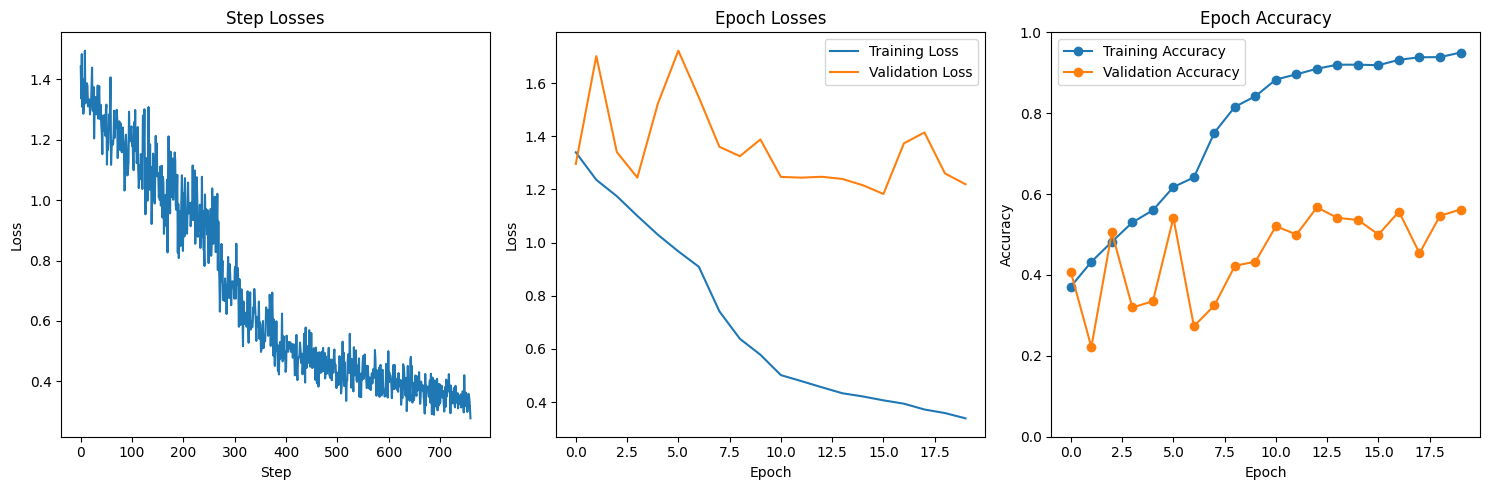

(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: title={'center': 'Step Losses'}, xlabel='Step', ylabel='Loss'>,
        <Axes: title={'center': 'Epoch Losses'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Epoch Accuracy'}, xlabel='Epoch', ylabel='Accuracy'>],
       dtype=object))

In [76]:
plot_history(history = history)


Confusion Matrix:
 [[13 11  3  3]
 [15 60  9  3]
 [ 3  7  5  2]
 [ 4 12  5 12]]
Test Accuracy: 53.89% | Precision: 0.466 | Recall: 0.445 | F1: 0.447


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


Predicted labels: [1 3 1 1 3 1 1 1 1 0 2 1 1 3 1 1 1 0 2 1 1 1 0 2 0 2 2 1 1 0 1 3 1 0 0 2 3
 0 1 1 0 1 1 1 0 0 3 1 0 0 1 1 2 1 1 3 0 3 0 1 1 2 1 1]
True labels: [1 3 2 1 0 0 1 1 3 1 1 1 1 1 1 1 3 1 2 1 1 3 1 1 1 3 1 1 1 2 1 0 2 1 0 3 1
 0 1 0 1 1 1 1 3 0 3 1 1 1 3 1 0 3 0 3 1 3 2 1 1 1 3 1]


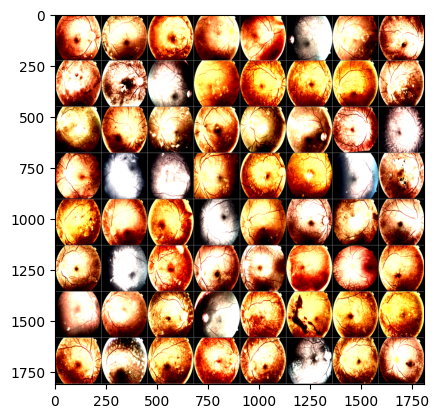

In [77]:
metrics, cm = evaluate_model(
    model_rsg,
    test_loader_four_classes,
    show_confusion=True
)

# Make predictions on a few sample images
sample_images, sample_labels = next(iter(test_loader_four_classes))
sample_images = sample_images.to(device) # Move sample_images to the same device as the model
sample_preds = model_rsg(sample_images)
sample_preds_labels = torch.argmax(sample_preds, dim=1).cpu().numpy() # Move predictions back to CPU for numpy conversion


print("Predicted labels:", sample_preds_labels)
print("True labels:", sample_labels.numpy())

imshow(torchvision.utils.make_grid(sample_images.cpu())) # Move images back to CPU for imshow

In [ ]:
cleanup_torch_env("model_rsg")

In [ ]:
def model_fn():
    return RSGNet()

run_experiments_to_single_csv(
        model_fn=model_fn,
        train_loader=loader_selected_four_classes,
        val_loader=val_loader_four_classes,
        test_loader=test_loader_four_classes,
        param_grid=grid_four_classes,
        model_name="RSGNet",
        csv_folder = base_path+"/results/",
        num_epochs=30,
        device=device,
        model_output_softmax = False
    )

# ResNet18

In [ ]:
model_resnet18 = models.resnet18(weights='DEFAULT')
print(model_resnet18)

In [ ]:
model_resnet18 = models.resnet18(weights='IMAGENET1K_V1')
print(model_resnet18)

In [ ]:
print(type(model_resnet18))


In [ ]:
# 2) Replace the last layer ("fc") with number of classes (5)
model_resnet18.fc = nn.Linear(model_resnet18.fc.in_features, 5)

In [ ]:
summary(model_resnet18, input_size=( batch_size, 3, img_size, img_size))

In [ ]:
history, model_resnet18 = train_model(
    model = model_resnet18,
    train_loader = train_loader_four_classes,
    val_loader = val_loader_four_classes,
    criterion_name = "crossentropy",
    optimizer_name = "sgd",
    lr=0.01,
    num_epochs = 20,
    device = device,
    scheduler_name = "reducelronplateau"
)

# Simone's Model

### Legacy

In [62]:
class Simone(nn.Module):                                                                                                                                                                                
    def __init__(self):
        super(Simone, self).__init__()
        # creating the layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, stride=1, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout(p=0.2)  # 20% di dropout
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.dropout2 = nn.Dropout(p=0.2)  # 20% di dropout
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=128*int(img_size/4)*int(img_size/4), out_features=128)
        self.dropout3 = nn.Dropout(p=0.5)  # 50% di dropout
        self.fc2 = nn.Linear(in_features=128, out_features=5)

    def forward(self, x):
        # Employing the layers
        x = self.conv1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, 128*int(img_size/4)*int(img_size/4))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout3(x)  # applico dropout solo durante il training
        x = self.fc2(x)

        return x

In [63]:
model_simone = Simone()
print(model_simone)
summary(model_simone, input_size=(batch_size, 3, img_size, img_size))

Simone(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=401408, out_features=128, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Simone                                   [64, 5]                   --
├─Conv2d: 1-1                            [64, 32, 224, 224]        896
├─Dropout: 1-2                           [64, 32, 224, 224]        --
├─Conv2d: 1-3                            [64, 64, 224, 224]        18,496
├─MaxPool2d: 1-4                         [64, 64, 112, 112]        --
├─Conv2d: 1-5                            [64, 128, 112, 112]       73,856
├─Dropout: 1-6                           [64, 128, 112, 112]       --
├─Conv2d: 1-7                            [64, 128, 112, 112]       147,584
├─MaxPool2d: 1-8                         [64, 128, 56, 56]         --
├─Linear: 1-9                            [64, 128]                 51,380,352
├─Dropout: 1-10                          [64, 128]                 --
├─Linear: 1-11                           [64, 5]                   645
Total params: 51,621,829
Trainable params: 51,621,829
Non-trai

In [ ]:
history, model_simone = train_model(
    model = model_simone,
    train_loader = train_loader_four_classes,
    val_loader = val_loader_four_classes,
    criterion_name = "crossentropy",
    optimizer = "adam",
    lr=1e-3,
    num_epochs = 30,
    device = device,
    scheduler_name=""
)

In [ ]:
plot_history(history = history)

In [ ]:
metrics, cm = evaluate_model(
    model_simone,
    test_loader_four_classes,
    show_confusion=True
)

# Make predictions on a few sample images
sample_images, sample_labels = next(iter(test_loader_four_classes))
sample_images = sample_images.to(device) # Move sample_images to the same device as the model
sample_preds = model_simone(sample_images)
sample_preds_labels = torch.argmax(sample_preds, dim=1).cpu().numpy() # Move predictions back to CPU for numpy conversion


print("Predicted labels:", sample_preds_labels)
print("True labels:", sample_labels.numpy())

imshow(torchvision.utils.make_grid(sample_images.cpu())) # Move images back to CPU for imshow

In [ ]:
cleanup_torch_env("model_simone")

In [ ]:
def model_fn():
    return Simone()

run_experiments_to_single_csv(
        model_fn=model_fn,
        train_loader=loader_selected_four_classes,
        val_loader=val_loader_four_classes,
        test_loader=test_loader_four_classes,
        param_grid=grid_four_classes,
        model_name="Simone",
        csv_folder = base_path+"/results/",
        num_epochs=30,
        device=device
    )

### Binary

In [ ]:
class SimoneBinary(nn.Module):                                                                                                                                                                                
    def __init__(self):
        super(SimoneBinary, self).__init__()
        # creating the layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, stride=1, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout(p=0.2)  # 20% di dropout
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.dropout2 = nn.Dropout(p=0.2)  # 20% di dropout
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=128*int(img_size/4)*int(img_size/4), out_features=128)
        self.dropout3 = nn.Dropout(p=0.5)  # 50% di dropout
        self.fc_binary = nn.Linear(in_features=128, out_features=1)

    def forward(self, x):
        # Employing the layers
        x = self.conv1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, 128*int(img_size/4)*int(img_size/4))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout3(x)  # applico dropout solo durante il training
        x = self.fc_binary(x)

        return x.squeeze(1)

In [ ]:
model_simone = SimoneBinary()
print(model_simone)
summary(model_simone, input_size=(batch_size, 3, img_size, img_size))

In [ ]:
history, model_simone = train_model(
    model = model_simone,
    train_loader = train_loader_binary,
    val_loader = val_loader_binary,
    criterion_name = "bce_logits",
    optimizer_name = "adam",
    lr=1e-3,
    num_epochs = 20,
    device = device,
    scheduler_name="",
    model_output_binary=True,
    verbose=True
)

In [ ]:
plot_history(history = history)

In [ ]:
metrics, cm = evaluate_model(
    model_simone,
    test_loader_binary,
    show_confusion=True,
    average="binary"
)

# Make predictions on a few sample images
# Use the BINARY loader for the binary model
sample_images, sample_labels = next(iter(test_loader_binary))

sample_images = sample_images.to(device)

with torch.no_grad():
    sample_logits = model_simone(sample_images)      # [B] or [B, 1]

    if sample_logits.dim() == 2 and sample_logits.size(1) == 1:
        sample_logits = sample_logits.squeeze(1)  # [B]

    sample_probs = torch.sigmoid(sample_logits)   # [B]
    sample_preds = (sample_probs >= 0.5).long()   # 0/1

sample_preds_labels = sample_preds.cpu().numpy()

print("Predicted labels:", sample_preds_labels)
print("True labels:", sample_labels.numpy())

imshow(torchvision.utils.make_grid(sample_images.cpu()))


In [64]:
cleanup_torch_env("model_simone")

### 4-class classification

In [66]:
class Simone4Class(nn.Module):                                                                                                                                                                                
    def __init__(self):
        super(Simone4Class, self).__init__()
        # creating the layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, stride=1, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout(p=0.2)  # 20% di dropout
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.dropout2 = nn.Dropout(p=0.2)  # 20% di dropout
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=128*int(img_size/4)*int(img_size/4), out_features=128)
        self.dropout3 = nn.Dropout(p=0.5)  # 50% di dropout
        self.fc2 = nn.Linear(in_features=128, out_features=4)

    def forward(self, x):
        # Employing the layers
        x = self.conv1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, 128*int(img_size/4)*int(img_size/4))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout3(x)  # applico dropout solo durante il training
        x = self.fc2(x)

        return x

In [67]:
model_simone = Simone4Class()
print(model_simone)
summary(model_simone, input_size=(batch_size, 3, img_size, img_size))

Simone4Class(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=401408, out_features=128, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Simone4Class                             [64, 4]                   --
├─Conv2d: 1-1                            [64, 32, 224, 224]        896
├─Dropout: 1-2                           [64, 32, 224, 224]        --
├─Conv2d: 1-3                            [64, 64, 224, 224]        18,496
├─MaxPool2d: 1-4                         [64, 64, 112, 112]        --
├─Conv2d: 1-5                            [64, 128, 112, 112]       73,856
├─Dropout: 1-6                           [64, 128, 112, 112]       --
├─Conv2d: 1-7                            [64, 128, 112, 112]       147,584
├─MaxPool2d: 1-8                         [64, 128, 56, 56]         --
├─Linear: 1-9                            [64, 128]                 51,380,352
├─Dropout: 1-10                          [64, 128]                 --
├─Linear: 1-11                           [64, 4]                   516
Total params: 51,621,700
Trainable params: 51,621,700
Non-trai

In [69]:
history, model_simone = train_model(
    model = model_simone,
    train_loader = loader_selected_four_classes,
    val_loader = val_loader_four_classes,
    criterion_name = "crossentropy",
    optimizer_name = "adam",
    lr=1e-3,
    num_epochs = 15,
    device = device,
    scheduler_name="",
    verbose=True,
    model_output_binary=False
)

Epoch 1/15


Epoch 1 training loss: 1.8378 train acc=0.2500, validation loss: 1.4072 validation acc=0.2062
Epoch 2/15


Epoch 2 training loss: 1.3875 train acc=0.2329, validation loss: 1.4030 validation acc=0.2062
Epoch 3/15


Epoch 3 training loss: 1.3870 train acc=0.2450, validation loss: 1.3991 validation acc=0.1134
Epoch 4/15


Epoch 4 training loss: 1.3868 train acc=0.2404, validation loss: 1.3982 validation acc=0.1134
Epoch 5/15


Epoch 5 training loss: 1.3868 train acc=0.2512, validation loss: 1.3956 validation acc=0.1134
Epoch 6/15


Epoch 6 training loss: 1.3867 train acc=0.2342, validation loss: 1.3944 validation acc=0.1134
Epoch 7/15


Epoch 7 training loss: 1.3866 train acc=0.2400, validation loss: 1.3946 validation acc=0.1134
Epoch 8/15


Epoch 8 training loss: 1.3866 train acc=0.2487, validation loss: 1.3931 validation acc=0.1134
Epoch 9/15


Epoch 9 training loss: 1.3865 train acc=0.2504, validation loss: 1.3919 validation acc=0.2062
Epoch 10/15


Epoch 10 training loss: 1.3864 train acc=0.2392, validation loss: 1.3896 validation acc=0.2062
Epoch 11/15


Epoch 11 training loss: 1.3863 train acc=0.2475, validation loss: 1.3902 validation acc=0.1134
Epoch 12/15


Epoch 12 training loss: 1.3863 train acc=0.2596, validation loss: 1.3881 validation acc=0.2062
Epoch 13/15


Epoch 13 training loss: 1.3865 train acc=0.2471, validation loss: 1.3889 validation acc=0.1134
Epoch 14/15


Epoch 14 training loss: 1.3864 train acc=0.2479, validation loss: 1.3877 validation acc=0.2062
Epoch 15/15


Epoch 15 training loss: 1.3864 train acc=0.2467, validation loss: 1.3872 validation acc=0.1134


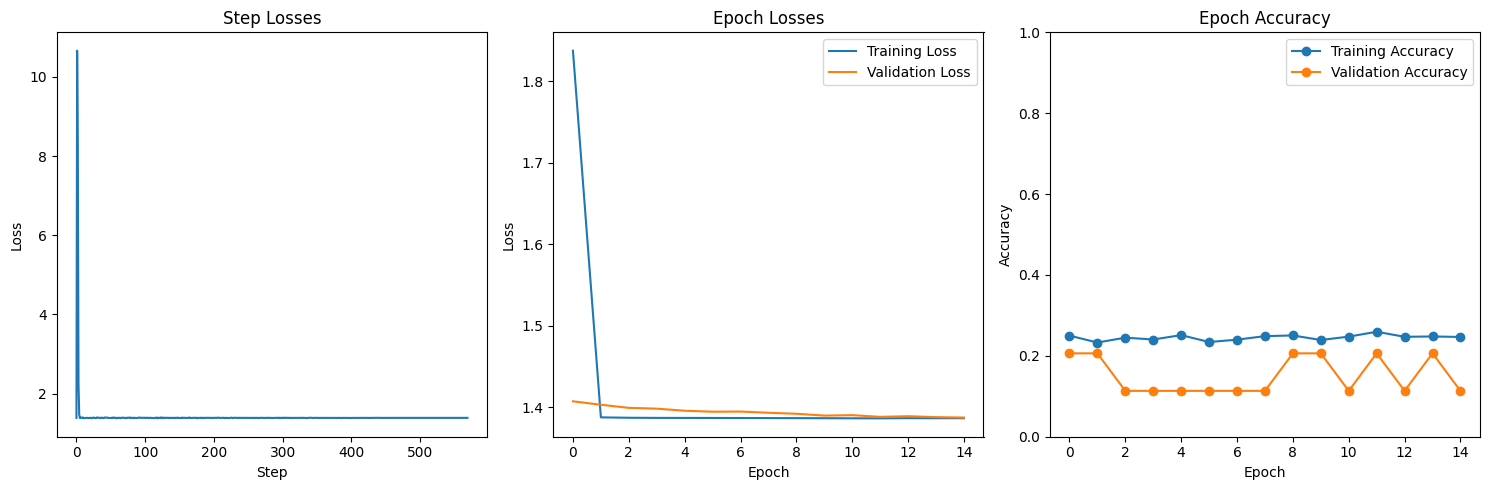

(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: title={'center': 'Step Losses'}, xlabel='Step', ylabel='Loss'>,
        <Axes: title={'center': 'Epoch Losses'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Epoch Accuracy'}, xlabel='Epoch', ylabel='Accuracy'>],
       dtype=object))

In [70]:
plot_history(history = history)


Confusion Matrix:
 [[  0   0 199]
 [  0   0 167]
 [  0   0   0]]
Test Accuracy: 0.00% | Precision: 0.000 | Recall: 0.000 | F1: 0.000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


Predicted labels: [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
True labels: [0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 1 0 1 1 1 0 1
 1 0 1 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 1 0 0 0 1 1 0 1]


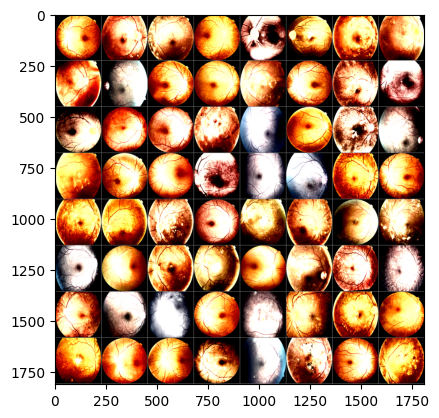

In [71]:
metrics, cm = evaluate_model(
    model_simone,
    test_loader_binary,
    show_confusion=True
)

# Make predictions on a few sample images
# Use the BINARY loader for the binary model
sample_images, sample_labels = next(iter(test_loader_binary))

sample_images = sample_images.to(device)

with torch.no_grad():
    sample_logits = model_simone(sample_images)      # [B] or [B, 1]

    if sample_logits.dim() == 2 and sample_logits.size(1) == 1:
        sample_logits = sample_logits.squeeze(1)  # [B]

    sample_probs = torch.sigmoid(sample_logits)   # [B]
    sample_preds = (sample_probs >= 0.5).long()   # 0/1

sample_preds_labels = sample_preds.cpu().numpy()

print("Predicted labels:", sample_preds_labels)
print("True labels:", sample_labels.numpy())

imshow(torchvision.utils.make_grid(sample_images.cpu()))

# Simone2's Model

In [59]:
class Simone2(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32,32,3,padding=1),   nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1),   nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64,128,3,padding=1),  nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.gap = nn.AdaptiveAvgPool2d(30)  # output: (B,128,1,1)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(128*30*30, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 4)
        )
    def forward(self, x):
        x = self.body(x)
        x = self.gap(x)
        x = self.head(x)
        return x

In [60]:
model_simone2 = Simone2()
print(model_simone2)
summary(model_simone2, input_size=(batch_size, 3, img_size, img_size))

Simone2(
  (body): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (gap): AdaptiveAvgPool2d(output_size=30)
  (head): Sequential(
    (0)

Layer (type:depth-idx)                   Output Shape              Param #
Simone2                                  [64, 4]                   --
├─Sequential: 1-1                        [64, 128, 56, 56]         --
│    └─Conv2d: 2-1                       [64, 32, 224, 224]        896
│    └─BatchNorm2d: 2-2                  [64, 32, 224, 224]        64
│    └─ReLU: 2-3                         [64, 32, 224, 224]        --
│    └─Conv2d: 2-4                       [64, 32, 224, 224]        9,248
│    └─BatchNorm2d: 2-5                  [64, 32, 224, 224]        64
│    └─ReLU: 2-6                         [64, 32, 224, 224]        --
│    └─MaxPool2d: 2-7                    [64, 32, 112, 112]        --
│    └─Conv2d: 2-8                       [64, 64, 112, 112]        18,496
│    └─BatchNorm2d: 2-9                  [64, 64, 112, 112]        128
│    └─ReLU: 2-10                        [64, 64, 112, 112]        --
│    └─Conv2d: 2-11                      [64, 128, 112, 112]       73,856
│ 

In [61]:
history, model_simone2 = train_model(
    model = model_simone2,
    train_loader = loader_selected_four_classes,
    val_loader = val_loader_four_classes,
    criterion_name = "crossentropy",
    optimizer_name = "adam",
    num_epochs = 15,
    device = device,
    scheduler_name="",
    lr=1e-3,
    model_output_binary=False,
    verbose=True
)

Epoch 1/15


Epoch 1 training loss: 6.2696 train acc=0.2725, validation loss: 1.2917 validation acc=0.4948
Epoch 2/15


Epoch 2 training loss: 1.3680 train acc=0.2921, validation loss: 1.3666 validation acc=0.5361
Epoch 3/15


Epoch 3 training loss: 1.3820 train acc=0.2804, validation loss: 1.3669 validation acc=0.5206
Epoch 4/15


Epoch 4 training loss: 1.3619 train acc=0.3267, validation loss: 1.3922 validation acc=0.2887
Epoch 5/15


Epoch 5 training loss: 1.3482 train acc=0.3308, validation loss: 1.3610 validation acc=0.5258
Epoch 6/15


Epoch 6 training loss: 1.3485 train acc=0.3433, validation loss: 1.3622 validation acc=0.5052
Epoch 7/15


Epoch 7 training loss: 1.3380 train acc=0.3475, validation loss: 1.3660 validation acc=0.4845
Epoch 8/15


Epoch 8 training loss: 1.3411 train acc=0.3337, validation loss: 1.3603 validation acc=0.5000
Epoch 9/15


Epoch 9 training loss: 1.3328 train acc=0.3463, validation loss: 1.3601 validation acc=0.5000
Epoch 10/15


KeyboardInterrupt: 

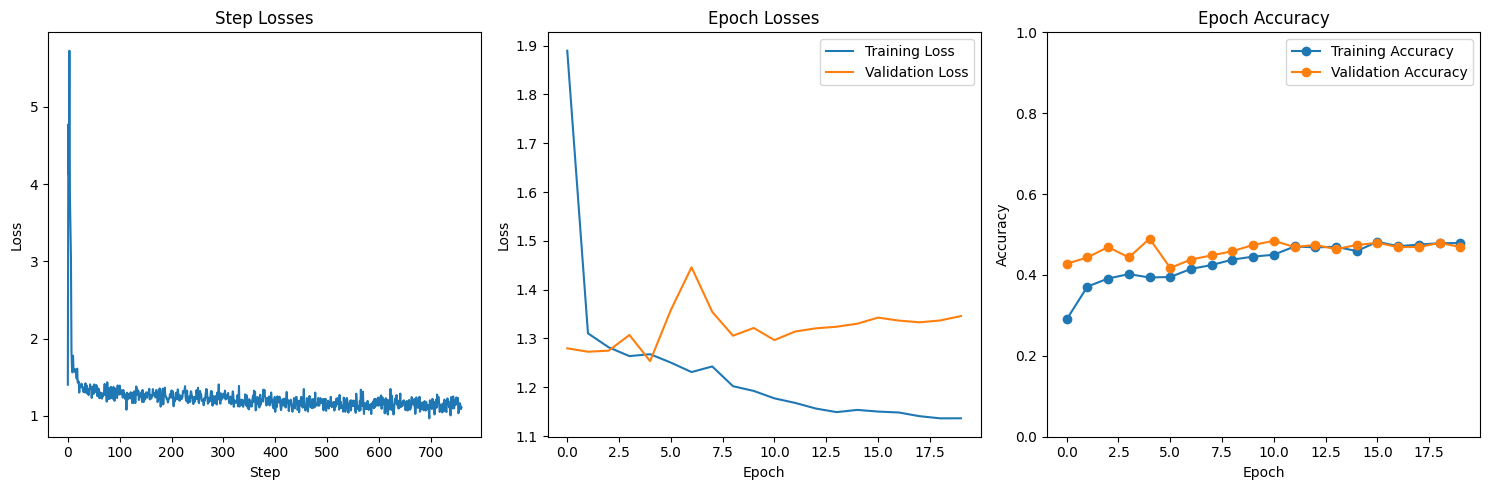

(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: title={'center': 'Step Losses'}, xlabel='Step', ylabel='Loss'>,
        <Axes: title={'center': 'Epoch Losses'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Epoch Accuracy'}, xlabel='Epoch', ylabel='Accuracy'>],
       dtype=object))

In [56]:
plot_history(history = history)


Confusion Matrix:
 [[ 3 25  1  1]
 [ 3 79  1  4]
 [ 1 14  1  1]
 [ 3 25  1  4]]
Test Accuracy: 52.10% | Precision: 0.376 | Recall: 0.297 | F1: 0.280


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


Predicted labels: [1 1 1 1 0 1 1 1 1 1 3 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 3 1 1]
True labels: [1 3 2 1 0 0 1 1 3 1 1 1 1 1 1 1 3 1 2 1 1 3 1 1 1 3 1 1 1 2 1 0 2 1 0 3 1
 0 1 0 1 1 1 1 3 0 3 1 1 1 3 1 0 3 0 3 1 3 2 1 1 1 3 1]


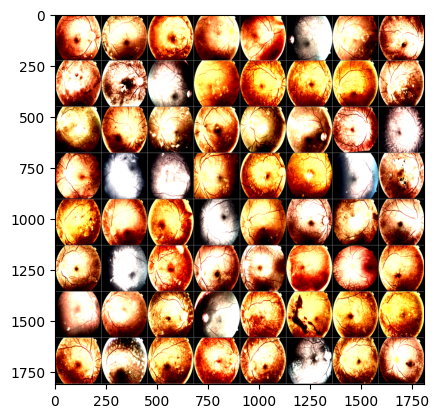

In [57]:
metrics, cm = evaluate_model(
    model_simone2,
    test_loader_four_classes,
    show_confusion=True
)

# Make predictions on a few sample images
sample_images, sample_labels = next(iter(test_loader_four_classes))
sample_images = sample_images.to(device) # Move sample_images to the same device as the model
sample_preds = model_simone2(sample_images)
sample_preds_labels = torch.argmax(sample_preds, dim=1).cpu().numpy() # Move predictions back to CPU for numpy conversion


print("Predicted labels:", sample_preds_labels)
print("True labels:", sample_labels.numpy())

imshow(torchvision.utils.make_grid(sample_images.cpu())) # Move images back to CPU for imshow

In [65]:
cleanup_torch_env("model_simone2")

In [ ]:
def model_fn():
    return Simone2()

run_experiments_to_single_csv(
        model_fn=model_fn,
        train_loader=loader_selected_four_classes,
        val_loader=val_loader_four_classes,
        test_loader=test_loader_four_classes,
        param_grid=grid_four_classes,
        model_name="Simone2",
        csv_folder = base_path+"/results/",
        num_epochs=5,
        device=device
    )